# MASH Modulator (3rd Order)

Copyright (C) 2026 Harald Pretl and co-authors (harald.pretl@jku.at)

Licensed under the Apache License, Version 2.0

This notebook implements a 3rd order MASH (1-1-1) modulator that converts a constant input value (0-1) into a multi-bit sequence. The output shows the time-domain sequence, individual stage outputs, and its spectrum via FFT.

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## MASH Modulator Class

The MASH (Multi-stAge noise SHaping) modulator consists of three cascaded 1st-order stages with digital noise cancellation logic.

In [2]:
class MASHModulator:
    """3rd order MASH (Multi-stAge noise SHaping) modulator"""
    
    def __init__(self):
        """Initialize the 3-stage MASH modulator."""
        # Three 1st order stages
        self.integrator1 = 0.0
        self.integrator2 = 0.0
        self.integrator3 = 0.0
        
        # Storage for digital cancellation logic (need 2 delays)
        self.y1_prev = 0
        self.y1_prev2 = 0
        self.y2_prev = 0
        self.y2_prev2 = 0
        self.y3_prev = 0
        self.y3_prev2 = 0
    
    def reset(self):
        """Reset all states to zero"""
        self.integrator1 = 0.0
        self.integrator2 = 0.0
        self.integrator3 = 0.0
        self.y1_prev = 0
        self.y1_prev2 = 0
        self.y2_prev = 0
        self.y2_prev2 = 0
        self.y3_prev = 0
        self.y3_prev2 = 0
    
    def step(self, input_value):
        """
        Perform one step of MASH modulation.
        
        Parameters:
        -----------
        input_value : float
            Input signal value (0-1)
        
        Returns:
        --------
        tuple
            (combined_output, y1, y2, y3) - combined output and individual stage outputs
        """
        # Stage 1: 1st order modulator with input signal
        self.integrator1 += input_value
        y1 = 1 if self.integrator1 >= 1.0 else 0
        e1 = self.integrator1 - y1  # Quantization error
        self.integrator1 = e1  # Store error for next iteration
        
        # Stage 2: 1st order modulator fed with quantization error from stage 1
        self.integrator2 += e1
        y2 = 1 if self.integrator2 >= 1.0 else 0
        e2 = self.integrator2 - y2
        self.integrator2 = e2
        
        # Stage 3: 1st order modulator fed with quantization error from stage 2
        self.integrator3 += e2
        y3 = 1 if self.integrator3 >= 1.0 else 0
        e3 = self.integrator3 - y3
        self.integrator3 = e3
        
        # Digital noise cancellation logic for MASH 1-1-1
        # Output = Y1 + (1-z^-1)*Y2 + (1-z^-1)^2*Y3
        # Expanding (1-z^-1)^2 = 1 - 2*z^-1 + z^-2:
        # Output = Y1 + Y2 - Y2[z^-1] + Y3 - 2*Y3[z^-1] + Y3[z^-2]
        
        combined = y1 + (y2 - self.y2_prev) + (y3 - 2*self.y3_prev + self.y3_prev2)
        
        # Update delay elements
        self.y1_prev2 = self.y1_prev
        self.y1_prev = y1
        
        self.y2_prev2 = self.y2_prev
        self.y2_prev = y2
        
        self.y3_prev2 = self.y3_prev
        self.y3_prev = y3
        
        return combined, y1, y2, y3
    
    def modulate(self, input_value, length, dither_amplitude=0.0, seed=None):
        """
        Generate MASH modulated sequence.
        
        Parameters:
        -----------
        input_value : float
            Constant input value (0-1)
        length : int
            Length of output sequence
        dither_amplitude : float
            Peak dither amplitude added to input (uniform in [-A, +A])
        seed : int or None
            RNG seed for reproducible dithering
        
        Returns:
        --------
        tuple
            (combined_output, y1, y2, y3) - arrays of combined and individual outputs
            Combined output range: -3 to +4 (multi-bit output)
        """
        self.reset()
        rng = np.random.default_rng(seed)
        combined_output = np.zeros(length)
        y1_output = np.zeros(length)
        y2_output = np.zeros(length)
        y3_output = np.zeros(length)
        
        for i in range(length):
            dither = rng.uniform(-dither_amplitude, dither_amplitude) if dither_amplitude > 0 else 0.0
            combined, y1, y2, y3 = self.step(input_value + dither)
            combined_output[i] = combined
            y1_output[i] = y1
            y2_output[i] = y2
            y3_output[i] = y3
        
        return combined_output, y1_output, y2_output, y3_output

## Configuration Parameters

Set the input parameters for the MASH modulator simulation.

In [3]:
# Parameters
input_value = 0.125  # Constant input (0-1)
sequence_length = 2**15  # Length of sequence
display_samples = 100  # Number of samples to display in time plot
dither_seed = 0  # RNG seed for reproducible dithering (None for random)

# Dithering configurations to compare
dither_amplitude_no_dither = 0.0  # No dithering
dither_amplitude_with_dither = 0.000001  # With dithering

print("=" * 60)
print("MASH 3rd Order Modulator - Dithering Comparison")
print("=" * 60)
print(f"Input Value:           {input_value}")
print(f"Sequence Length:       {sequence_length}")
print(f"Dither (no):           {dither_amplitude_no_dither}")
print(f"Dither (with):         {dither_amplitude_with_dither}")
print("=" * 60)

MASH 3rd Order Modulator - Dithering Comparison
Input Value:           0.125
Sequence Length:       32768
Dither (no):           0.0
Dither (with):         1e-06


## Generate MASH Sequence

Create the modulator instance and generate the output sequence.

In [4]:
# Create modulator
mash = MASHModulator()

# Generate sequence WITHOUT dithering
print("\nGenerating MASH sequence WITHOUT dithering...")
mash_combined_no_dither, mash_y1_no_dither, mash_y2_no_dither, mash_y3_no_dither = mash.modulate(
    input_value,
    sequence_length,
    dither_amplitude=dither_amplitude_no_dither,
    seed=dither_seed,
)

# Generate sequence WITH dithering
print("Generating MASH sequence WITH dithering...")
mash_combined_with_dither, mash_y1_with_dither, mash_y2_with_dither, mash_y3_with_dither = mash.modulate(
    input_value,
    sequence_length,
    dither_amplitude=dither_amplitude_with_dither,
    seed=dither_seed,
)


Generating MASH sequence WITHOUT dithering...
Generating MASH sequence WITH dithering...


## Statistics

Analyze the output statistics of the MASH modulator.

In [5]:
print("\nMASH Modulator Statistics:")
print("\n--- WITHOUT Dithering ---")
mash_mean_no = np.mean(mash_combined_no_dither)
mash_min_no = np.min(mash_combined_no_dither)
mash_max_no = np.max(mash_combined_no_dither)
mash_unique_no = np.unique(mash_combined_no_dither)
print(f"  Mean output:       {mash_mean_no:.6f}")
print(f"  Deviation:         {abs(mash_mean_no - input_value):.6f}")
print(f"  Output range:      {mash_min_no:.0f} to {mash_max_no:.0f}")
print(f"  Unique values:     {len(mash_unique_no)}")

print("\n--- WITH Dithering ---")
mash_mean_with = np.mean(mash_combined_with_dither)
mash_min_with = np.min(mash_combined_with_dither)
mash_max_with = np.max(mash_combined_with_dither)
mash_unique_with = np.unique(mash_combined_with_dither)
print(f"  Mean output:       {mash_mean_with:.6f}")
print(f"  Deviation:         {abs(mash_mean_with - input_value):.6f}")
print(f"  Output range:      {mash_min_with:.0f} to {mash_max_with:.0f}")
print(f"  Unique values:     {len(mash_unique_with)}")


MASH Modulator Statistics:

--- WITHOUT Dithering ---
  Mean output:       0.125000
  Deviation:         0.000000
  Output range:      -2 to 2
  Unique values:     5

--- WITH Dithering ---
  Mean output:       0.125000
  Deviation:         0.000000
  Output range:      -3 to 3
  Unique values:     7


## Visualization - Comparison

Compare MASH modulator outputs with and without dithering.

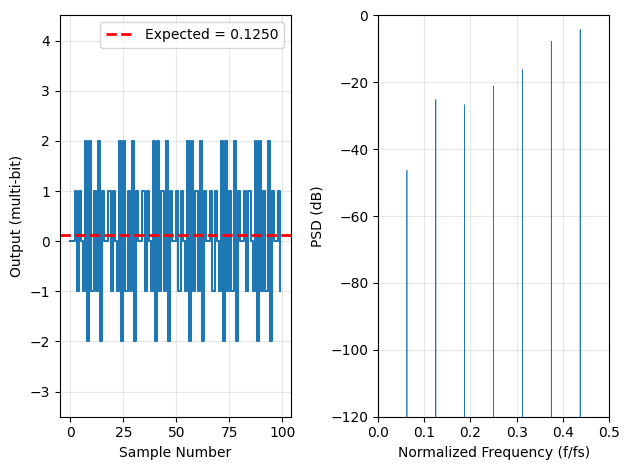

In [6]:
#| label: fig-mash-nodither
#| fig-cap: "Time series and the spectrum of a MASH 3rd-order modulator."
fig = plt.figure()

time = np.arange(min(display_samples, len(mash_combined_no_dither)))

# Plot 1: Time domain (no dither)
ax1 = plt.subplot(1, 2, 1)
ax1.step(time, mash_combined_no_dither[:display_samples], where='post', linewidth=1.5, color='C0')
ax1.axhline(y=input_value, color='r', linestyle='--', linewidth=2, 
            label=f'Expected = {input_value:.4f}')
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Output (multi-bit)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(-3.5, 4.5)

# Plot 2: Frequency spectrum (no dither)
ax2 = plt.subplot(1, 2, 2)
N = len(mash_combined_no_dither)
fft_freq = np.fft.fftfreq(N)
pos_freq = fft_freq >= 0
fft_no = np.fft.fft(mash_combined_no_dither)
psd_no = 20 * np.log10(np.abs(fft_no) / N + 1e-12)
ax2.plot(fft_freq[pos_freq], psd_no[pos_freq], linewidth=0.5, color='C0')
ax2.set_xlabel('Normalized Frequency (f/fs)')
ax2.set_ylabel('PSD (dB)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 0.5)
ax2.set_ylim(-120, 0)

plt.tight_layout()
plt.show()

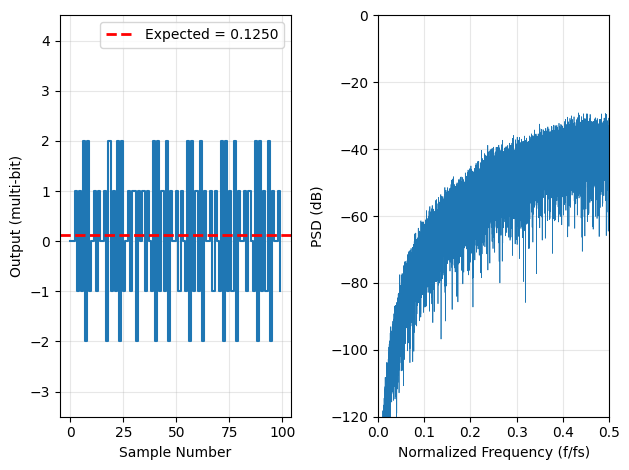

In [7]:
#| label: fig-mash-dither
#| fig-cap: "Time series and the spectrum of a MASH 3rd-order modulator with added dither."
fig = plt.figure()

time = np.arange(min(display_samples, len(mash_combined_with_dither)))

# Plot 1: Time domain (with dither)
ax1 = plt.subplot(1, 2, 1)
ax1.step(time, mash_combined_with_dither[:display_samples], where='post', linewidth=1.5, color='C0')
ax1.axhline(y=input_value, color='r', linestyle='--', linewidth=2, 
            label=f'Expected = {input_value:.4f}')
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Output (multi-bit)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(-3.5, 4.5)

# Plot 2: Frequency spectrum (with dither)
ax2 = plt.subplot(1, 2, 2)
N = len(mash_combined_with_dither)
fft_freq = np.fft.fftfreq(N)
pos_freq = fft_freq >= 0
fft_no = np.fft.fft(mash_combined_with_dither)
psd_no = 20 * np.log10(np.abs(fft_no) / N + 1e-12)
ax2.plot(fft_freq[pos_freq], psd_no[pos_freq], linewidth=0.5, color='C0')
ax2.set_xlabel('Normalized Frequency (f/fs)')
ax2.set_ylabel('PSD (dB)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 0.5)
ax2.set_ylim(-120, 0)

plt.tight_layout()
plt.show()